<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>

![im](images/banner.png)


<font face="Calibri">

# Multiscale sediment dynamics

<br>
<font size="3"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<b>This notebook covers the following concepts:</b>

- The ProfileDynamics class
- Multiscale volumetric analysis and plotting
- Hotspot analysis
- Multiscale beachface Cluster Dynamics indices and plotting
</font>

In [13]:
%matplotlib notebook

from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sb

from sandpyper.common import sensitivity_tr_rbcd, plot_sensitivity_rbcds_transects
from sandpyper.sandpyper import ProfileDynamics

pd.options.mode.chained_assignment = None  # default='warn'

Let's load the previously created ProfileSet object.

In [14]:
# set the test data folder path
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

ProfileSet_path=Path(test_data_folder + r"\test.p")

In [15]:
P=pickle.load(open(ProfileSet_path, "rb"))

___

## Introduction

In this notebook, we finally get some dynamics data out of our profiles using the __ProfileDynamics__ class.



### ProfileDynamics class

The __ProfileDynamics__ class is the core object in sandpyper. Its methods allows to:

* compute multitemporal elevation changes
* compute Limit of Detections (LoDs) statistics
* compute multi-scale volumetrics
* discretise elevation changes into discrete classes of magnite of changes with a variety of methods (thanks to the Python package [pysal](https://pysal.org/))
* compute multi-scale beachface cluster dynamics indices (BCDs, check the paper [Pucino et al., 2021](https://www.nature.com/articles/s41598-021-83477-6.epdf?sharing_token=844tVeK37MSYJoNEThYGItRgN0jAjWel9jnR3ZoTv0PxEZXr8bbQlsWb42PNMTsu53flRyY9FJ3fI5pe-Atcf1RbRfb5zpR7Q0KX8rhHKlN-viewjBsZvEcrYBcliJPElRIl7UYdYDwJS94n1E_4gLskgni0xLdXl8TujAjpfG8%3D))
* various plotting capabilities

In [16]:
labels=["Undefined", "Small", "Medium", "High", "Extreme"]

Here below we instantiate a ProfileDynamics object which discretises the data into 5 bins using the Jenks and Caspall method. We also provides labels to the bins, in order to be able to name them and keep the analysis clear. 

In [17]:
D = ProfileDynamics(P, bins=5, method="JenksCaspall", labels=labels)

Data will be partitioned into 5 discrete classes.
Labels provided.


### Computing multitemporal dataset (dh_df)

The method *ProfileDynamics.compute_multitemporal* allows to:

1. create pairwise (date from - date to) elevation difference dataset called dh_df
2. option to filter data based on a class. For instance, computing elevationc hanges of sand only
3. option to provide a dictionary to use full length location names instead of location codes in some plots (loc_full)

Once run, this will add an attribute called *dh_df* that stores the dataframe of elevation changes across all the surveys and time periods.
If LoD was previously derived with LoD transects, this method will also compute lod_dh table, which is used to create an LoD table.

Let's see how this work.

In [18]:
D.compute_multitemporal(loc_full={'mar': 'Marengo',
         'leo': 'St. Leonards'}, filter_class='sand')

Filter activated: only ['sand'] points will be retained.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
done
Computing LoD dh data.
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
done


We can see that mutlitemporal statistics have been computed for each time period in all locations, creating the dh_df dataframe.

In [25]:
D.dh_df.head()

,geometry,location,tr_id,distance,class_filter,dt,date_pre,date_post,z_pre,z_post,dh
0,POINT (731628.744 5705535.887),mar,24,22.0,sand,dt_7,20190313,20190516,1.177169,0.517324,-0.659844
1,POINT (731627.918 5705536.452),mar,24,23.0,sand,dt_7,20190313,20190516,1.176551,0.679524,-0.497027
2,POINT (731627.093 5705537.016),mar,24,24.0,sand,dt_7,20190313,20190516,1.182770,0.768895,-0.413875
3,POINT (731626.267 5705537.581),mar,24,25.0,sand,dt_7,20190313,20190516,1.183118,0.863863,-0.319256
4,POINT (731625.442 5705538.145),mar,24,26.0,sand,dt_7,20190313,20190516,1.183118,0.906839,-0.276280


The __dt__ column stores a 'time-period ID'. For instance, in St. Leonards, the changes of points from (20180606) to (20180713) is named dt_0, because it is the first time period in this location. The second one, (20180713) to (20180920) is named dt_1 and so on.

All the information about time periods are stored into a dataframe as an attribute called *ProfileDynamics.dh_details*.

In [26]:
D.dh_details

,dt,date_pre,date_post,location,n_days,loc_full
0,dt_0,20180606,20180713,leo,37,St. Leonards
1,dt_1,20180713,20180920,leo,69,St. Leonards
2,dt_2,20180920,20190211,leo,144,St. Leonards
3,dt_3,20190211,20190328,leo,45,St. Leonards
4,dt_4,20190328,20190731,leo,125,St. Leonards
5,dt_0,20180601,20180621,mar,20,Marengo
6,dt_1,20180621,20180727,mar,36,Marengo
7,dt_2,20180727,20180925,mar,60,Marengo
8,dt_3,20180925,20181113,mar,49,Marengo
9,dt_4,20181113,20181211,mar,28,Marengo


In the same way the dh_df dataframes has been computed, the lod_dh table is also computed, except that no filters are applied and all points previously extracted from the LoD transects are used.

In [27]:
D.lod_dh.head()

,geometry,location,tr_id,distance,class_filter,dt,date_pre,date_post,z_pre,z_post,dh,dh_abs
0,POINT (299959.041 5773365.227),leo,7,0,no_filters_applied,dt_4,20190328,20190731,1.252971,1.221372,-0.031598,0.031598
1,POINT (299959.299 5773364.260),leo,7,1,no_filters_applied,dt_4,20190328,20190731,1.250840,1.237120,-0.013720,0.013720
2,POINT (299959.556 5773363.294),leo,7,2,no_filters_applied,dt_4,20190328,20190731,1.264070,1.245647,-0.018423,0.018423
3,POINT (299959.813 5773362.328),leo,7,3,no_filters_applied,dt_4,20190328,20190731,1.266122,1.241259,-0.024862,0.024862
4,POINT (299960.070 5773361.361),leo,7,4,no_filters_applied,dt_4,20190328,20190731,1.262709,1.276591,0.013882,0.013882


From this dataset, a set of useful error (i.e, elevation change in calibration areas where a theoretical zero change should occur) statistics is also computed, which include:

1. mean (column: 'mean')
2. median (column: 'med')
3. standard deviation (column: 'std')
4. normalised medain absolute deviation (column: 'nmad')
5. 68.3th quantile of absolute error (column: 'a_q683')
6. 95th quantile of absolute error (column: 'a_q95')
7. robust root mean squared error (column: 'rrmse')
8. number of total observations (column: 'n')
9. n_outliers using the 3-sigma method (column: 'n_outliers')
10. Shapiro–Wilk statistics, p-values and normality evaluation (columns: 'saphiro_stat', 'saphiro_p', 'saphiro_normality')
11. D’Agostino–Pearson statistics, p-values and normality evaluation (columns: 'ago_stat', 'ago_p', 'agoo_normality')
12. the chosen Limit of Detection based on normality check (column: 'lod')

All this information is stored in the **lod_df** attribute.

In [28]:
D.lod_df.head()

,location,dt,mean,med,std,nmad,a_q683,a_q95,rrmse,n,n_outliers,saphiro_stat,saphiro_p,ago_stat,ago_p,saphiro_normality,ago_normality,lod
0,leo,dt_0,-0.016272,-0.064292,0.150259,0.101219,0.112612,0.345512,0.119911,93,0,0.858607,5.912969e-08,37.326988,7.844181e-09,not normal,not normal,0.101219
1,leo,dt_1,-0.174044,-0.169029,0.219942,0.111155,0.217434,0.587310,0.202302,93,3,0.828144,5.102937e-09,48.123011,3.549940e-11,not normal,not normal,0.111155
2,leo,dt_2,0.055579,0.031193,0.237583,0.071532,0.082824,0.478929,0.078037,93,0,0.621792,4.005841e-14,83.112916,8.959002e-19,not normal,not normal,0.071532
3,leo,dt_3,0.034389,0.070812,0.212526,0.111180,0.142241,0.419897,0.131816,93,2,0.822265,3.284433e-09,33.561621,5.154500e-08,not normal,not normal,0.111180
4,leo,dt_4,0.012034,0.006063,0.178835,0.098167,0.097641,0.393089,0.098354,93,1,0.815170,1.953578e-09,51.212861,7.573009e-12,not normal,not normal,0.098167


### Plot: LoD normality check

To choose which metric to use as LoD, given that LoD can be interpreted as the expected error in the DoD (DSM of Difference, basically the subtraction of two DSMs representing the landscape in two consecutive times), it is necessary to evaluate the normality of the statistical distribution of errors (values of changing elevations in calibration areas which are supposed not to be changing).

>[See the docs](https://npucino.github.io/sandpyper/extraction%20and%20lod/?h=normality#limits-of-detection-lod-thresholds, "Limits of detection and normality assumption discussion") for more info on why we evaluate normality of errors!

Eventhough statistical tests can be useful in identifying wether a distribution is normal or not, especially in the case of photogrammetrically derived products, it is advised to also visually check both the histograms and the Q-Q plots of absolute error.

Sandpyper allows quick and easy generation of such plots, here is an example for Marengo.

<IPython.core.display.Javascript object>


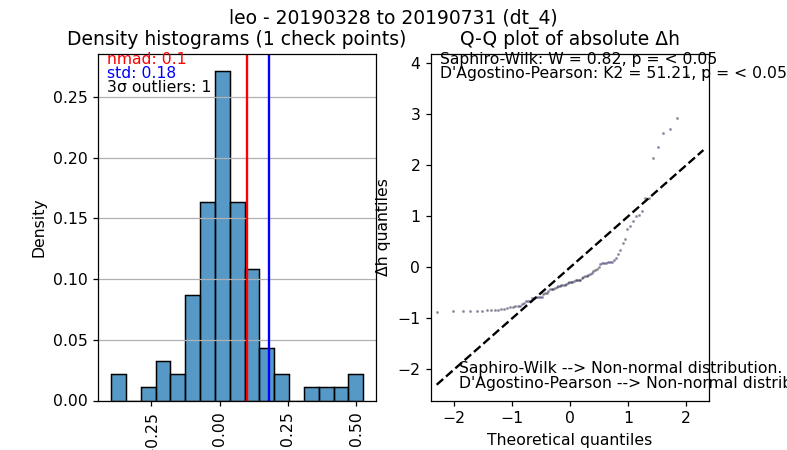

<IPython.core.display.Javascript object>


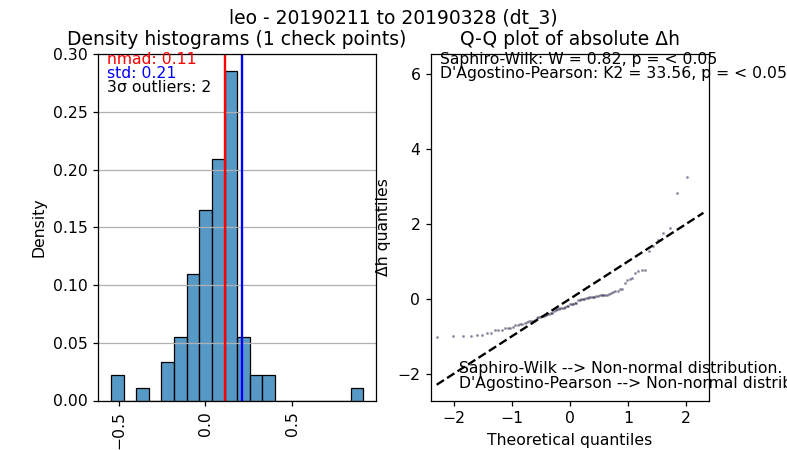

<IPython.core.display.Javascript object>


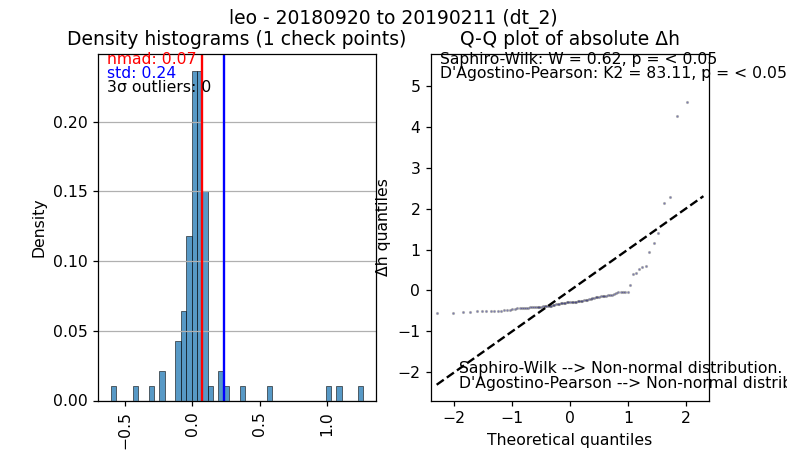

<IPython.core.display.Javascript object>


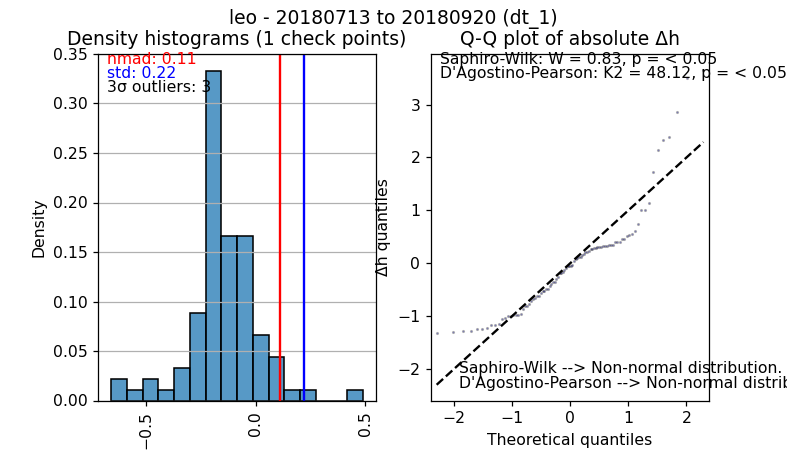

<IPython.core.display.Javascript object>


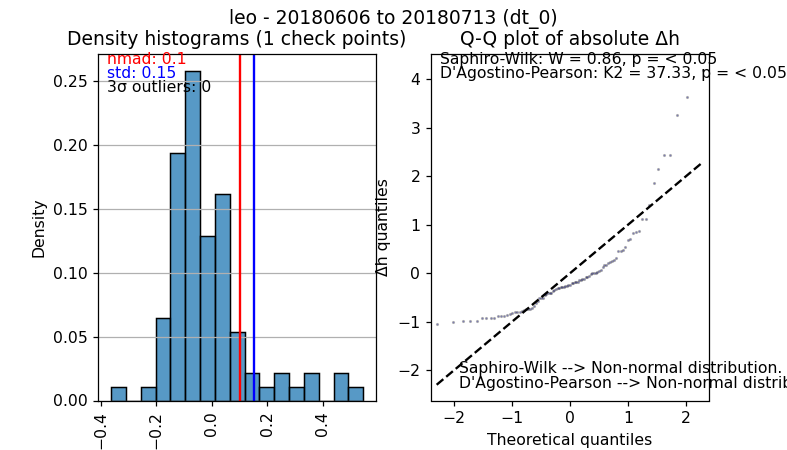

In [29]:
D.plot_lod_normality_check(locations=['leo'])

In all the above cases, the normality assumption is violated, as a consequence of both statistical testing and Q-Q plot visualisation.
This implies that the 'usual' standard deviation and root mean squared errors estimators shouldn't be used in these cases as vertical errors metrics (hence LoD) as they silently assume a normal distribution, which we proved not to be the case.

Therefore, robust estimators needs to be used. Sandpyper automatically computes the normalised median absolute deviation (nmad) metric, which is reported to be a more robust estimator for elevation precision of photogrammetric products [Hole and Hole, 2009](https://www.sciencedirect.com/science/article/abs/pii/S0924271609000276?via%3Dihub "Accuracy assessment of digital elevation models by means of robust statistical methods, ISPRS"), and decides wether to use RMSE or NMAD as error metric based on the result of the normality check.

In fact, the `D.lod_df` table has already taken care of this:
>The __lod__ column will hold the computed NMAD values in case of non-normality or the RMSE in case of normality.

## Multiscale volumetrics

With the LoD and dh_df tables we are finally ready to observe multi-scale change.

### Mean Elevation Change

The __Mean Elevation Change (MEC)__ is calculated with the totality of the valid points (filtered based on class, beyond LoD, within the beachface) that occur both in the pre and post dataset in each location.<br>
MEC is the preferred metric as it allows a robust comparison between locations and time, given a context where number of transects and retained valid points can drastically change from time to time or from location to locatio due to changes in:

- survey extent
- wave run-up and the swash level
- non-sand points across the beachface

### Volumetric estimation from profiles

The __volumes of beachface change__, instead, are estimated, using the following procedure.

1. Along each transect, the missing points (due to non-sand filters if applied) are replaced by a linearly interpolated value.
2. We integrate the change along the cleaned transect to estimated volumetric change at each transect.
3. We multiply the sum of all transect volume change by the transect spacing, to obtain a location-level beachface change estimation.

This approximation is necessary to go from transect change to beachface change. Here below is how Sandpyper takes care of that in one line, computing multi-scale MECs and volumetrics in one line, by just calling the *ProfileDynamics.compute_volumetrics* method.

This will add two additional dataframes as attributes, named __location_volumetrics__ and __transects_volumetrics__, which will store a number of statistics.

In [30]:
# compute volumetrics

D.compute_volumetrics(lod=D.lod_df)

Using LoDs.


In [31]:
D.location_volumetrics.head()

,location,location_full,dt,date_from,date_to,n_days,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,leo,St. Leonards,dt_0,20180606,20180713,37,9.489928,-20.506530,-11.016602,-0.018994,0.041082,-0.088773,-0.047691,134.334184,-362.662966,-228.328782,-0.393670,231
1,leo,St. Leonards,dt_1,20180713,20180920,69,18.725955,-9.525609,9.200346,0.016429,0.085507,-0.043496,0.042011,322.445395,-103.237953,219.207442,0.391442,219
2,leo,St. Leonards,dt_2,20180920,20190211,144,15.840791,-7.481373,8.359419,0.014928,0.076158,-0.035968,0.040190,285.138428,-138.500707,146.637721,0.261853,208
3,leo,St. Leonards,dt_3,20190211,20190328,45,10.163696,-11.862978,-1.699282,-0.002930,0.040015,-0.046705,-0.006690,181.204725,-171.608277,9.596448,0.016546,254
4,leo,St. Leonards,dt_4,20190328,20190731,125,6.105440,-29.049858,-22.944418,-0.040972,0.026896,-0.127973,-0.101077,89.599553,-511.175997,-421.576444,-0.752815,227


Amongst the varios statistics computed (__check the docs for details__), the most important fields are:

- norm_net_change: abs_net_change/total number of points used in the calculation of this time period (n_obs_valid). This is the MEC.
- net_vol_change: Net volume change (m3)
- location_m3_m: Net volume change / beach length (m3/m)
- cum: Cumulative net volume change since the beginning of the monitoring (m3)
- cum_mec: Cumulative norm_net_change since the beginning of the monitoring (m3)

Let's use sandpyper to visualise these stats.

### Plot: multi-scale MECS and volumetrics

#### Transect-level

The method *ProfileDynamics.plot_transects* allow to visualise elevation profile changes in selected locations, tr_ids and time periods. COnveniently, if the data has been classified, by setting the parameter __classified=True__ we can also see what class each point was classified into.

>__NOTE__: if __classified=False__, the points that have been filtered out will not be displayed. If __classified=True__, then all points will be plotted. This is done to have a visual understanding of the cleaning procedure applied and appreciate what is actually retained to compute change statistics. 

<IPython.core.display.Javascript object>


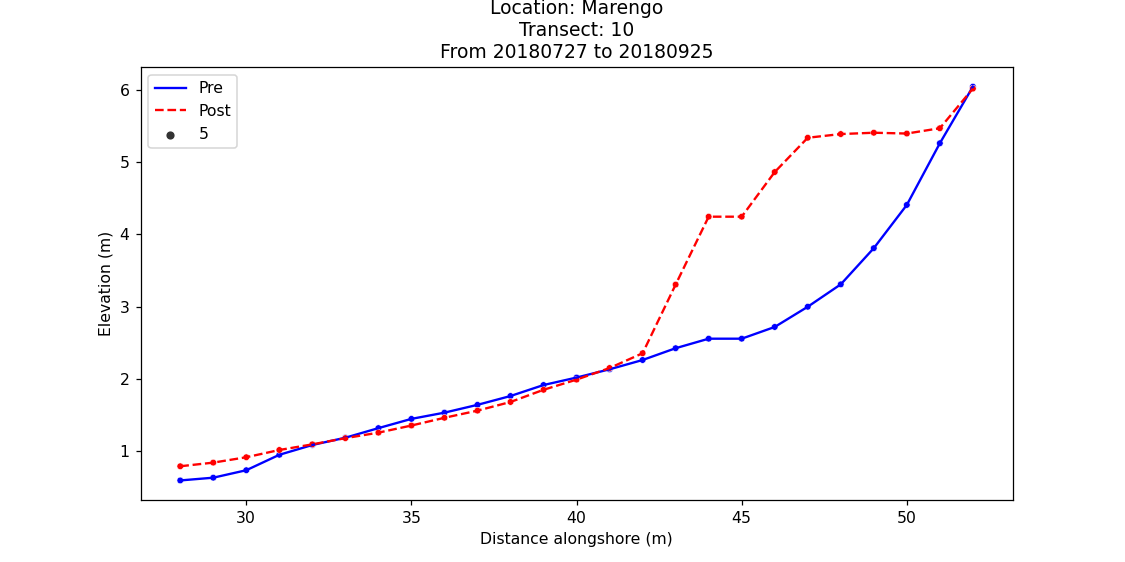

In [32]:
# let's plot transect ID 10 in Marengo, for dt_2 and dt_3 with no classification applied.

D.plot_transects(location='mar', tr_id=10, from_date='20180727', to_date='20180925', classified=False)

<IPython.core.display.Javascript object>


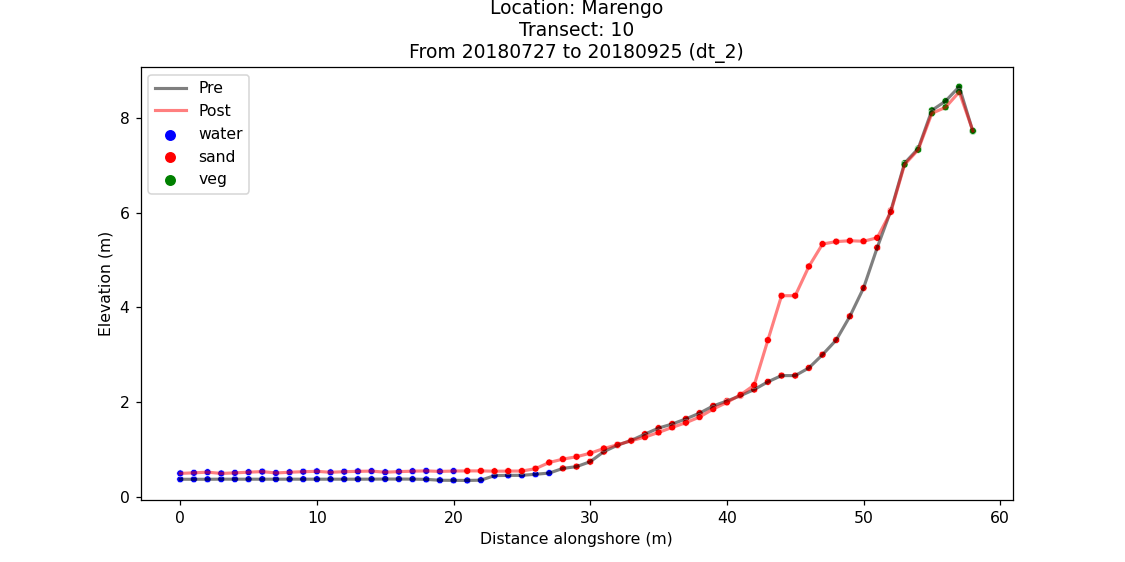

<IPython.core.display.Javascript object>


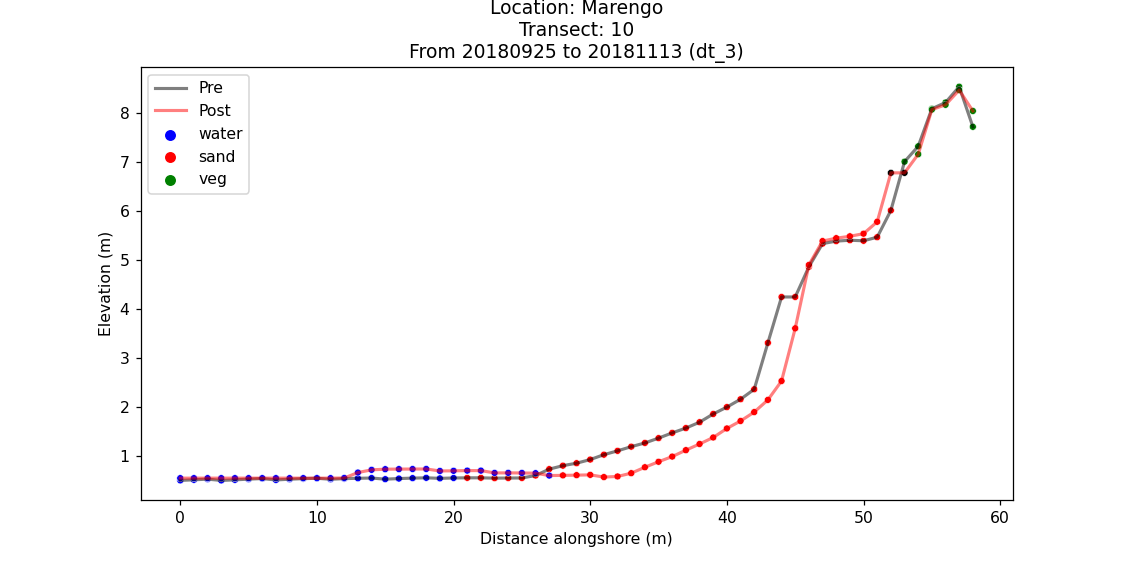

In [33]:
# same, with classification applied.

D.plot_transects(location='mar', tr_id=10, dt=['dt_2','dt_3'], classified=True)

In the above example, we can see how a major sand nourishment interention built a considerable foredune during dt_2. However, as it is shown in dt_3, this intervation did't last long, as the sand got eroded and the profile started receding again.

To have a full overview of a transect history all in one place, Sandpyper can plot it for you, with the option of using LoD to filter only reliable change (above LoD) or retain all points.

<IPython.core.display.Javascript object>


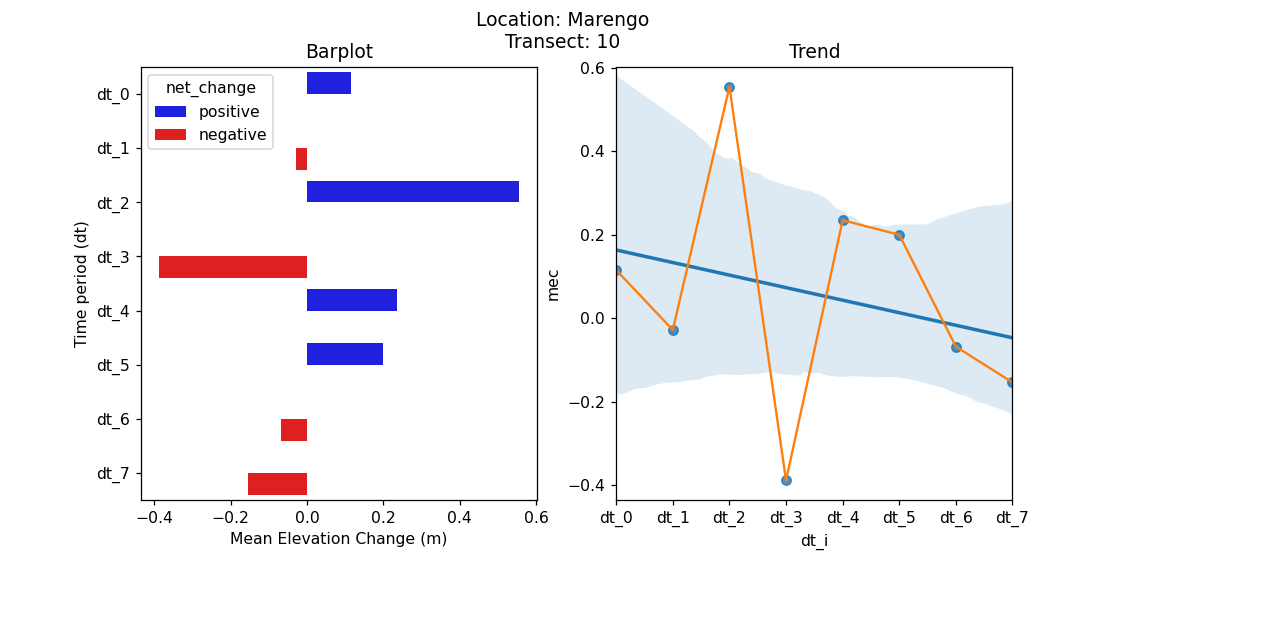

Statistics are computed based on the following classes only: sand


In [34]:
# plots mean elevation change of transect ID 10 in marengo across all time periods
# no LoD filter is applied, all the points are retained.

D.plot_transect_mecs(location='mar',tr_id=10)

<IPython.core.display.Javascript object>


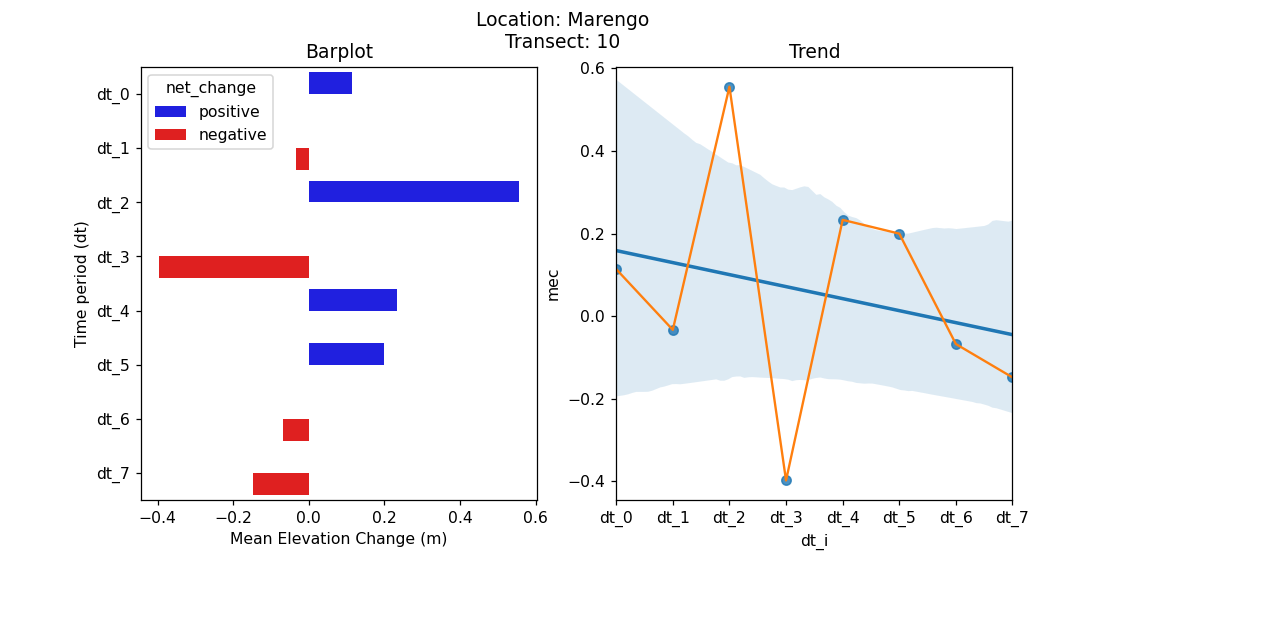

Using LoDs.
Statistics are computed based on the following classes only: sand


In [35]:
# same as above but with the LoD filter applied, therefore retaining only reliable elvation changes.

D.plot_transect_mecs(location='mar', lod=D.lod_df, tr_id=10)

As you can see above, visually the difference is not easily discernible.
However, if we do some math, we can quickly see that:

In [39]:
# store transect data, with lod
tr_10_lod=D.transects_volumetrics.query("location=='mar' and tr_id==10")

# recompute volumetrics, this time withouth lod
D.compute_volumetrics(lod=None)

# store transect data, without lod
tr_10_NoLod=D.transects_volumetrics.query("location=='mar' and tr_id==10")

No LoD is used.


In [41]:
tr_10_lod.norm_net_change - tr_10_NoLod.norm_net_change

149   -0.001500
170   -0.007271
191    0.001389
212   -0.009624
234   -0.001475
256    0.000123
275    0.000429
294    0.005260
Name: norm_net_change, dtype: float64

Or, we can also have use Sandpyper to plot both alongshore heatmaps of altimetric change and alongshore estimated volume changes, in all locations and all time-periods.

<IPython.core.display.Javascript object>


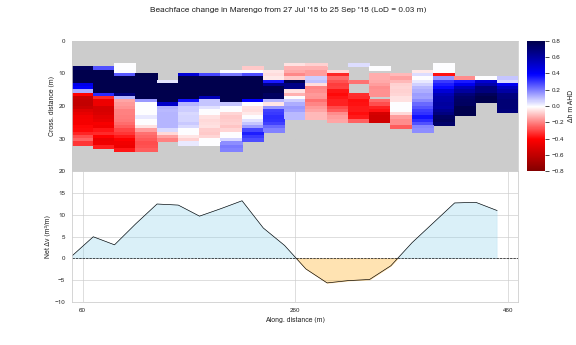

Working on mar at dt_2


<IPython.core.display.Javascript object>


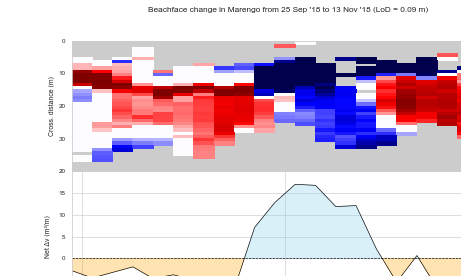

Working on mar at dt_3


In [63]:
D.plot_alongshore_change(mode='subset',       # to plot only a subset of locations and dts, rather than all
                         dt_subset=['dt_2', 'dt_3'],
                         location_subset=["mar"],
                         lod=D.lod_df, # LoD will be applied when provided in form of lod dataframe or single (global) value
                         ax2_y_lims=(-10, 20), # lineplot y axis limits
                        fig_size=(10,6),
                        font_scale=.9,
                        plots_spacing=0, # spacing between the two plots. Try .1, it is also nice
                        bottom=True,
                        y_heat_bottom_limit=40, # how far seawar the heatmap will extent.
                        heat_yticklabels_freq=10,
                        heat_xticklabels_freq=10,)

#### Location-level

So far we saw data and plots at the transect level. Let's see a few plots at the location level, starting with the *ProfileDynamics.plot_single_loc* method.

<IPython.core.display.Javascript object>


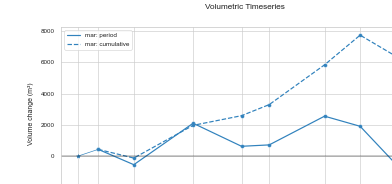

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [64]:
D.plot_single_loc(["mar"],None)

In the above plot we can appreciate the volume change timeseries of Marengo, with the solid line representing the period-specific change while the dashed line the cumulative change from the start of the monitoring.

Alternatively, we can plot both locations MECs timeseries in order to compare their elevational changes through time, using the method *ProfileDynamics.plot_mec_evolution*.

<IPython.core.display.Javascript object>


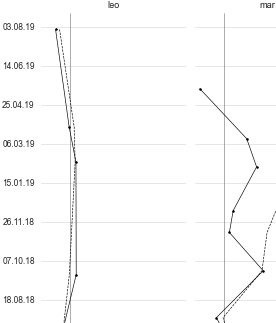

In [65]:
# scale_mode can be 'auto', which means the x axis is location-specific, or 'equal', better for comparison.

D.plot_mec_evolution(x_limits=(-.2, .8), scale_mode='equal',
                     loc_order=["leo","mar"],
                    x_binning=10,
                    figure_size=(6, 7),
                    font_scale=1.2)

<IPython.core.display.Javascript object>


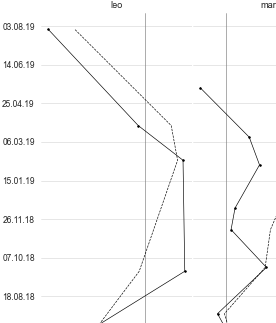

In [66]:
# scale_mode can be 'auto', which means the x axis is location-specific, or 'equal', better for comparison.

D.plot_mec_evolution(x_limits=(-.2, .8), scale_mode='auto',
                     loc_order=["leo","mar"],
                    x_binning=10,
                    figure_size=(6, 7),
                    font_scale=1.2)

Alternatively, if we want to change the x-axis of only specific locations, we can set the scale_mode='equal', provide x_lims, __and provide a dictionary where keys are the location codes and values the location specific limits.__ In this way we can keep all the analysis visually comparable, with some exceptions (different scale) provided with the dictionary in the __x_diff__ parameter.

```python
    x_diff = {'leo': [-0.12, 0.1]}
```

<IPython.core.display.Javascript object>


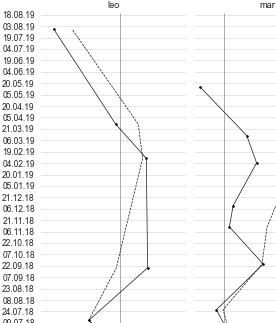

x_diff provided. Setting xlims of leo = (-0.12, 0.1) 
x_diff provided but mar not found. Setting xlims= (-0.2, 0.8) 


In [67]:
x_diff={'leo':[-0.12, 0.1]}

D.plot_mec_evolution(x_limits=(-.2, .8), scale_mode='equal',
                     x_diff=x_diff,
                     dates_step=15,
                     loc_order=["leo","mar"],
                    x_binning=10,
                    figure_size=(6, 7),
                    font_scale=1.2)

## Hotspot analysis: Local Indicator of Spatial Association (LISA)

In order to discard spatial outliers and get a better representation of the beachface dynamics by at the same time reducing the number of points analysed (in real-world case this can be an important aspect), we use the Local Moran's I index, which is one of the most used spatial autocorrelation measure, avalibale thanks to the great work in the Python package __[Pysal](https://pysal.org/)__.

The method __*ProfileDynamics.LISA_site_level*__ performs a Local Moran's I with False Discovery Rate (fdr) correction analysis for all the elevation change points in each survey in the __dh_df__ dataframe.

This method can use __KNN-based, inverse distance weighted or binary distance-based__ spatial weight matrices. In this example, we model spatial relationships with a distance-based row standardised binary weight matrix with neighborhood radius of __35 m__, in order to include two adjacent transect without getting too far from the focal point.

>__NOTE:__ When using the KNN mode, the value stored in the ```lisa_opt_distance``` column of the returned dataframe represents the number of neirest neighbors used, specified with the argument ```k_value```, and not an actual distance.

In [68]:
D.LISA_site_level(mode="knn", k_value=50)

  0%|          | 0/2 [00:00<?, ?it/s]

Working on mar


  0%|          | 0/8 [00:00<?, ?it/s]

Working on leo


  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
D.hotspots.shape

(5112, 23)

This method adds some hotspot analysis relevant columns to the dh_df table, most importantly:

- false discovery rate threshold (column: lisa_fdr)
- local Moran's I (column: lisa_I)
- simulated pseudo p and z values (columns: lisa_p_sim, lisa_z_value)
- Moran's scatter plot quadrant (column: lisa_q)

__MORAN SCATTERPLOT__ (High-High cluster, High-Low spatial outlier, Low-Low cluster and Low-High spatial outlier)

Although technically the High-High and Low-Low Moran's scatter plot quadrants represent statistically significant spatial clusters, we commonly refer to these points as hotspots and coldspots.

>__IMPORTANT NOTE__: Hot versus cold spots do not necessary reflect positive and negative values, rather, they represent statistically significan changes in the magnitude of the process analysed (elevationc change). Thus, in a scenario of extremely high deposition, hotspots represents high values of deposition surrounded by other high values of deposition, while coldspots represent low values of deposition surrounded by other low values of deposition. The choice of Local Moran's I as LISA has been motivated by the fact that we want to represent dynamics as best as we can by removing spatial outliers at the location level and we are not necessarily interested (at this stage) at the actual human interpretation (deposition vs erosion).


Now that we have statistically significant hotspots of change, we can use those points to capture the most interesting areas of beachface change which we use to model behaviour.

>__ANOTHER NOTE__:
Our beachfaces are narrow, and we use only reliable valid points using multiple levels of filtering (LoD, beachface area, sand-only), which significantly reduce the total number of usable points in each timestep.
Because in our next step we will compute the Beachface Cluster Dynamics indices both at the location and transect scales, we will use the hotspot filtering only at the location level and not at the transect level.
This is necessary to assure that we have enough points in each transect to model their behaviours.

<IPython.core.display.Javascript object>


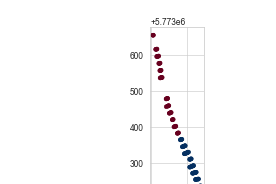

<AxesSubplot:>

In [70]:
D.hotspots.query("location=='leo' and dt=='dt_2' and lisa_q in [1,3]").plot(column='lisa_q', categorical=True,
                                                                            cmap='RdBu')

## Multiscale Beachface Cluster Dynamics (BCDs) indices

In this section, the Beachface Cluster Dynamics (BCDs), which compirse both the empirical and residual BCD indices, are computed with sandpyper.

> From [Pucino et al.](https://www.nature.com/articles/s41598-021-83477-6#Abs1),: " *The empirical and residual BCDs (e-BCD and r-BCD respectively) are purposefully designed metrics to leverage the very high spatiotemporal resolutions and three-dimensionality of our data for studying subaerial beach landform dynamics (morphodynamics). With elevation change (Δh) magnitude classes as transient states, we used finite discrete Markov chain models to compute first-order stochastic transition matrices and steady-state probability vectors, used to derive e- and r-BCD respectively.*" For more information about the methods, please refer to [the docs]().

As stated above, before computing any BCD, we need to discretise the magnitude of elevation change that occurred at every time step into bins.
When we intiate the ProfileSet instance we already provide sandpyper with all it need to perform the discretisation on the data.

Therefore it is as simple as calling the *ProfileDynamics.discretise* method, as shown below.

In [71]:
appendix=["_deposition", "_erosion"]

D.discretise(absolute=True, print_summary=True, lod=D.lod_df, appendix=appendix)

              JenksCaspall              
 
Lower          Upper               Count
        x[i] <= 0.108               1799
0.108 < x[i] <= 0.247               1515
0.247 < x[i] <= 0.453               1082
0.453 < x[i] <= 1.096                601
1.096 < x[i] <= 3.012                115

Fit of JenksCaspall with 5 bins: 254.46116716298275


By setting __absolute = True__, the bins will be derived from absolute values of elevation changes first, then, classes will be assigned to both negative and positive values accordingly. This is needed to ensure that both erosional and depositional classes represent the same interval in elevation change magnitudes, except of opposite sign.

After this step, a new dataframe is added named __df_labelled__, which stores the __markov_tag__ field, which is the result of the discretisation process.

Now, we are ready to compute the actual indices, but first, a note on the weights, neede for the e-BCDs.

### e-BCDs weights

The __e-BCD__ uses weights to represent the importance of each transition.<br>

A point that transitioned from small erosion to extreme erosion has more impact on the sediment budget than if it was transitioning to a medium erosion class.<br>
The weights for each magnitude class can be specified manually using a dictionary. However, it is best to obtain an objective representation of the severity of change. As the magnitude classes are derived from the data (using Jenks-Caspall optimised natural breaks method in this example), a simple yet robust solution is to use the medians of each magnitude class as weight.
<br>
<br>
The function __infer_weights__ takes care of this process.

In [72]:
D.infer_weights()

D.weights_dict

{'Undefined_deposition': 0.05,
 'Undefined_erosion': 0.05,
 'Small_deposition': 0.17,
 'Small_erosion': 0.17,
 'Medium_deposition': 0.33,
 'Medium_erosion': 0.33,
 'High_deposition': 0.58,
 'High_erosion': 0.58,
 'Extreme_deposition': 1.62,
 'Extreme_erosion': 1.62}

Of course, if we want to use our own designed weigths, it is as simple as this below:

In [73]:
# create the weight dictionary

my_weights_dict={'Undefined_deposition': 1,
 'Undefined_erosion': 1,
 'Small_deposition': 1,
 'Small_erosion': 1,
 'Medium_deposition': 1,
 'Medium_erosion': 1,
 'High_deposition': 3,
 'High_erosion': 3,
 'Extreme_deposition': 8,
 'Extreme_erosion': 8}

# add it to the ProfileDynamics object

D.weights_dict = my_weights_dict

D.weights_dict

{'Undefined_deposition': 1,
 'Undefined_erosion': 1,
 'Small_deposition': 1,
 'Small_erosion': 1,
 'Medium_deposition': 1,
 'Medium_erosion': 1,
 'High_deposition': 3,
 'High_erosion': 3,
 'Extreme_deposition': 8,
 'Extreme_erosion': 8}

However, it makes more sense to use Sandpyper in-built method, so, let's recalculate it.


In [74]:
D.infer_weights()

D.weights_dict

{'Undefined_deposition': 0.05,
 'Undefined_erosion': 0.05,
 'Small_deposition': 0.17,
 'Small_erosion': 0.17,
 'Medium_deposition': 0.33,
 'Medium_erosion': 0.33,
 'High_deposition': 0.58,
 'High_erosion': 0.58,
 'Extreme_deposition': 1.62,
 'Extreme_erosion': 1.62}

Now, we can compute BCDs at the location level at once.

The method *ProfileDynamics.BCDs_compute* computes all the stochastic first-order transition matrices of sand dynamics, based on the filters provided (sand-only, hotspots, beyond LoD) across beachfaces, at the site level, which are the basis for the e-BCDs.

It returns 2 dataframes:
* __e-BCDs__
* __steady-state distribution__

In [75]:
D.BCD_compute_location("geometry","all",True, filterit='lod')

LoD filter in use. Only points beyond LoDs will be retained.


After this step, two new dataframes are added as attributes to the ProfileDynamics object:
1. location_ebcds : stores the location level e-BCDs of each submatrix, as well as its value, sign and trend.
2. location_ss : stores the location level steady-state vector of each magnitude of change class

In [76]:
D.location_ebcds

,location,sub_matrix,coastal_markov_idx,trend,sign,states_labels
0,leo,de,2.096,2.625,+,Vulnerability
1,leo,dd,0.546,0.001,+,Depositional
2,leo,ed,1.731,-0.159,-,Recovery
3,leo,ee,0.924,-0.045,-,Erosional
4,mar,de,2.080,0.098,+,Vulnerability
5,mar,dd,1.477,0.044,+,Depositional
6,mar,ed,2.570,-0.253,-,Recovery
7,mar,ee,1.290,-0.027,-,Erosional


In [77]:
D.location_ss

,leo,mar
Extreme_deposition,0.000000,0.017774
High_deposition,0.009499,0.063266
Medium_deposition,0.056102,0.099950
Small_deposition,0.148219,0.106840
Undefined_deposition,0.017016,0.043324
total_deposition,0.230837,0.331154
Undefined_erosion,0.011688,0.027057
Small_erosion,0.143038,0.082955
Medium_erosion,0.070255,0.065048
High_erosion,0.007023,0.045040



The residual is simply the difference between erosional and depositional probabilities in the Steady-State distribution, __multiplicated by 100__ for readability purposes. Note that in this case, no weigths are applied as no transition is represented.


Here below, the dataframe returns the residual column, which is what you might want to map in Qgis.

The above table, the row __r_bcds__ represent the r-BCD index for the locations, which we also call __behavioural regime__.

### Plot: first-order transition stochastic matrices

Let's use sandpyper to visualise location-specific first-order stochastic matrices, representing the probability ofeach transiction, which is the basis for the computation of the e-BCDs.

In [78]:
# the following dictionary is used to rename the magnitude of change classes into small codes
#such as 'me' for Medium Erosion or 'sd' for Small Deposition. This is done purely for graphical purposes.

relabel_dict={'Undefined_deposition': 'ue',
 'Undefined_erosion': 'ue',
 'Small_deposition': 'sd',
 'Small_erosion': 'se',
 'Medium_deposition': 'md',
 'Medium_erosion': 'me',
 'High_deposition': 'hd',
 'High_erosion': 'he',
 'Extreme_deposition': 'ed',
 'Extreme_erosion': 'ee'}

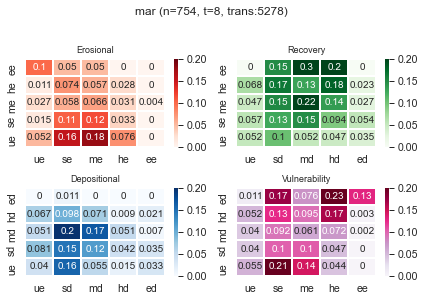

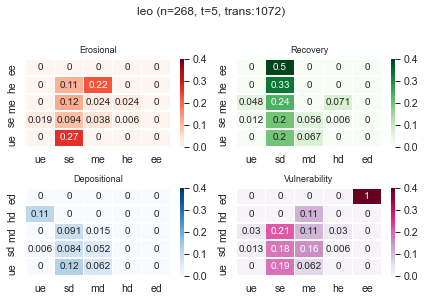

In [79]:
%matplotlib inline

#let's plot those matrices

D.plot_trans_matrices(relabel_dict)

Notes: <br>
>These matrices discard all the __valid to non-valid transitions__. In other words, all transitions going from a valid point (non spatial outlier, classified as sand and beyond limit of detection) are labelled as "nnn" and discarded.
Moreover, __the colour ramp__ higher limit (vmax parameter) is set to a maximum of 3 times the standard deviation of all dataset without the nnn state.

#### How to read transition matrices

__The title__ informs about:
* mar/leo = Location codes (leo = St. Leonards; mar = Marengo)
* n = Total number of points in the timeseries (valid and non-valid)
* t = Total number of timesteps
* trans = Total number of valid transitions considered

__Rows__ are the initial state, while the __columns__ are the final (one-step) state. For instance, in Marengo, a point which starting state is Undefined Erosion (ue) has 12% probability to become a Medium Erosion (me) point and a 15% probability to become a Medium Deposition in the next time period.  

__Some observations__
>We chose St. Leonards as an example to demonstrates a few limitations, which are observable in this matrix.

__St. Leonards__ is located within Port Phillip bay. This narrrow beach is not embayed, but __fetch-limited__, meaning that it doesn't receive the highly energetic Souther Ocean swell, rather, it sees its morphodynamics impacted by considerably lower waves which are locally generated from within the bay. Moreover, seagrass meadows and reefs further reduce wave imapcts on the subaerial beachface.<br>
Therefore, __changes are small__ and often below the limit of detections, thus, uncertain. If we consider that we filter points based on:

1. only sand
2. limit of detection
3. spatial outliers

from an already narrow beach (short transects) this location is severly decimated in terms of behavioural modelling potential. In fact, the submatrices have many zeroes, which indicate a zero probability of these transitions, because these have not been recorded during the monitoring period.
Moreover, we note how most of the transitions tend to be __from lower magnitude classes to low magnitude classes.__
Another story for Marengo. <br>

__Marengo__ is an open-ocean beach with a small southern section pretected by a small headland (tombolo-like). The section used for this example is also affected by sand nourishment, which injects considerable amount of sediment during the monitoring period.<br>
Given in Marengo we have roughly 4 times the number of valid observations (trans=5'278) as compared to St. Leonards (trans=1'072), the submatrices better capture the stochastic behaviour of this beachface.



### Plot: e-BCDs (location)

Let's plot the e-BCDs, which summarises the information contained in the submatrices.

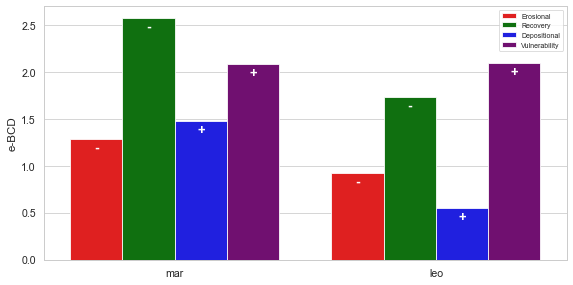

In [80]:
D.plot_location_ebcds(loc_order=['mar','leo'])

### Plot: r-BCD (location)

We already computed the __Steady State__ probability vectors for each location using the __BCDs_compute__ function, storing it in the __ss__ variable.<br>
Here below we reorder the data and plot as an heatmap, where each columns is a location and each row a magnitude of change.


In [81]:
order=[i for i in D.tags_order if i !='nnn']
ss=D.location_ss.loc[order] 
ss

,leo,mar
Extreme_deposition,0.000000,0.017774
High_deposition,0.009499,0.063266
Medium_deposition,0.056102,0.099950
Small_deposition,0.148219,0.106840
Undefined_deposition,0.017016,0.043324
Undefined_erosion,0.011688,0.027057
Small_erosion,0.143038,0.082955
Medium_erosion,0.070255,0.065048
High_erosion,0.007023,0.045040
Extreme_erosion,0.000897,0.003127


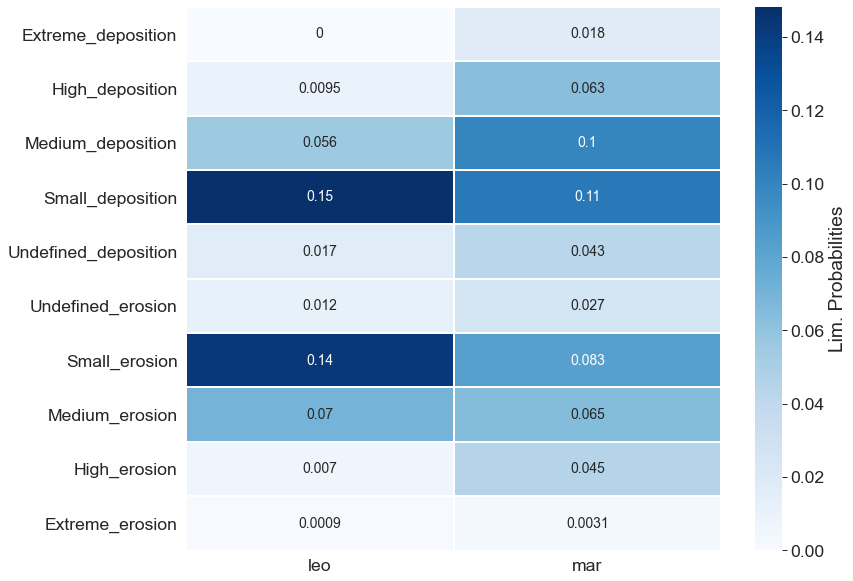

In [82]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)


f,ax=plt.subplots(figsize=(12,10))

sb.heatmap(ss, cmap="Blues",annot=True,
           annot_kws={'size':14},linewidths=1,linecolor="white", cbar_kws={'label': 'Lim. Probabilities'});

#f.savefig(r'E:\\path\\to\\save\\picture.png', dpi=600); 

Location level BCDs are good to compare multiple locations across wide areas. But what about getting a more detailed spatial-explicit view of the behaviour of a beachface system, at the __transect-level__?

### Transect-level BCDs 

If we are looking at spatial distribution of r-BCDs, it is important that transects are comparable to each other within one location. 

So far, LoDs and sand-only filters have assured that only high quality data was used in the r-BCDs computation. At the transect level we add two additional conditions, to ensure that are only retained:

1. points that remain valid for at least a certain amount of time periods
2. transects that have a number of valid points greater than a determined minimum threshold

Therefore, the choice of the two parameters (__thresh and min_pts__) of the *ProfileDynamics.BCD_compute_transects* method is very important:

1. __min_points__: the minimum required valid points per transect to consider a transect reliable.
2. __thresh__: the minimum number of timesteps required to retain a transect.

This is done to ensure comparability across time and transects in a determined location.
Therefore, __thresh__ is an important parameter that should ideally be as high as the available time periods, in order to ensure that the maximum behavioural variability is captured.<br>
Yet, setting this parameter very high can reduce considerably the number of valid points retained in a single transect, which in turn can fall below __min_pt__, leading to the loss of transects from the final behavioural map.<br>


Let's see how this works.

In [89]:
loc_specs={'mar':{'thresh':6,
       'min_points':6}}

D.BCD_compute_transects(loc_specs=loc_specs,reliable_action='keep', dirNameTrans=D.ProfileSet.dirNameTrans)

  0%|          | 0/2 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
No threshold and mi_points provided in loc_specs for leo. Using no filters.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

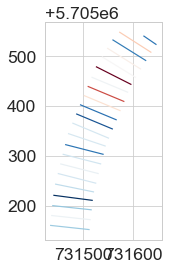

In [90]:
D.transects_rbcd.query("location=='mar'").plot(column="residual", cmap='RdBu_r')

Done. We now have transect level r-BCDS computed with the totality of elevation changes transitions occurred during the monitoring period.


#### Sensitivity analysis

However, as previously discussed, the choice of the __thresh and min_pts__ parameter is very important. It is also informative to monitor and try to minimise the number of transects that __passed from a depositional to erosional behavioral regime (or vice versa) in the last time period (i. e. changed sign from t-1 to t),__ for any chosen __thresh__. Those transects could signal a behaviour that only emerged by choosing a determined value for __thresh__, signaling a potentially __lower confidence in their r-BCD values__.<br>Also  choosing the right min_pts and thresh parameters is important.

This is why sandpyper includes 2 functions to perform a __sensitivity analysis__:

1. __sensitivity_tr_rbcd()__ : to perform a sensitivity analysis 
2. __plot_sensitivity_rbcds_transects()__ : to visualise the sensitivity analysis results


We start by defining all the combinations between the parameters __thresh (t)__ and __min_pts (pt)__, given ranges that we define.<br>
The thresh parameter can be up to the total number of timesteps available, while the min_pts, we decide to test the values from 0 to 210, with a step of 10.

In [41]:
ss_tr_big = sensitivity_tr_rbcd(D,
                                test_thresholds='max',
                                test_min_pts=[0,20,2])

Working on mar.
A total of 90 combinations of thresholds and min_pts will be computed.


  0%|          | 0/90 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on leo.
A total of 60 combinations of thresholds and min_pts will be computed.


  0%|          | 0/60 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 1 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 2 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 3 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 1 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 2 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

Working on threshold 3 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 4 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 1 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 2 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

Working on threshold 3 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 4 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


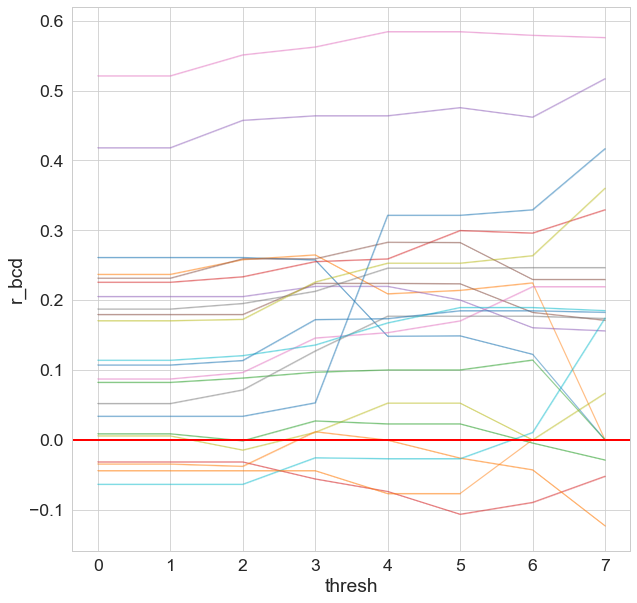

In [42]:
f,ax=plt.subplots(figsize=(10,10))

palette=sb.color_palette( n_colors=ss_tr_big.query("location=='mar'").tr_id.unique().shape[0])
sb.lineplot(data=ss_tr_big.query("location=='mar'"), x='thresh',y='residual', hue='tr_id', 
            palette=palette, legend=False, **dict(alpha=0.5),
            ax=ax
)
ax.set_ylabel("r_bcd")
ax.axhline(y=0, lw=2, c='r');

As you can see, the majority of the transects shows a negative or positive r-BCDS consistently through time. However, a few of them, flipped their sign (going  from depositional to erosional or viceversa) as a consequence of adding one extra timestep. 

In order to better decide a sub-optimal combination of thresh and min_pts that retains the majority of the transects, __while keeping an eye on more sensitive transects that flipped r-BCD__, the function __plot_sensitivity_rbcds_transects__ plots both the number of transects retained (valid) and the total sign changes as a function of the threshold used. This function creates a plot per min_points situation.

The solid black line is the 95th percentile of the total valid transect retained while the dashed one is the 85th.

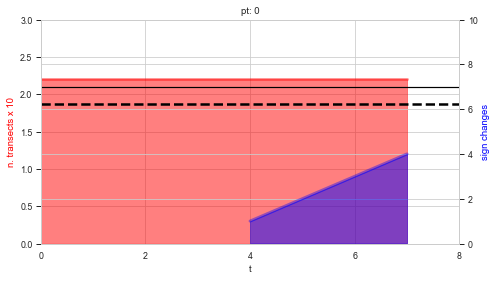

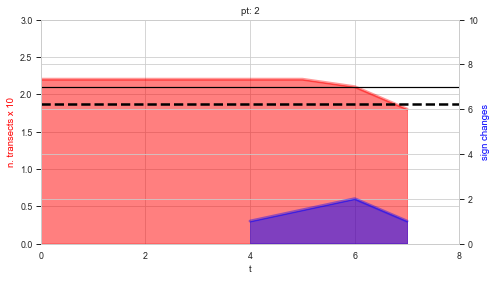

In [ ]:
plot_sensitivity_rbcds_transects(ss_tr_big, location='mar')

## Conclusion

This notebook concludes the tutorials for the profile-based monitoring approach offered by sandpyper. In the next notebook we introduce a paradigm shift, which is raster-based analysis. However, this part of sandpyper is currently under development, thus, only a small __teaser notebook__ will illustrate a few useful functions already implemented in sandpyper.

See you there!